<a href="https://colab.research.google.com/github/sreehari59/Polar-Embedding/blob/main/Polar_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gensim
from numpy import linalg
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook as tqdm
import time
from random import shuffle
import sys
import nltk 
from nltk.corpus import wordnet 
import gc
from collections import defaultdict
import random
import json
import os

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile

from gensim.test.utils import datapath

# This is for the plotly subplots
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# This is to load file from google drive
from google.colab import drive
drive.mount('/content/drive')

# This is to download csv file
from google.colab import files

import random
import scipy


!pip install ipython-autotime
%load_ext autotime

Mounted at /content/drive
time: 1.56 ms (started: 2022-05-17 00:42:59 +00:00)


In [2]:
def unzipping_file():
  !wget https://nlp.stanford.edu/data/glove.6B.zip
  !unzip glove*.zip # When it is unzipped you can see the different set of dimension it can have that is 25d, 50d, 100d or 200d

time: 1.5 ms (started: 2022-05-17 00:42:59 +00:00)


In [3]:
def model_initialization(unzippedname, new_name):
  model_glove = glove2word2vec(unzippedname,new_name)
  model_glove = gensim.models.KeyedVectors.load_word2vec_format(new_name, binary=False)
  return model_glove

time: 2.4 ms (started: 2022-05-17 00:42:59 +00:00)


In [4]:
def generate_norm_embedding(model, output_path):
    temp_file = open(output_path,'wb')
    temp_file.write(str.encode(str(len(model.vocab))+' '+str(model.vector_size)+'\n'))
    
    for each_word in tqdm(model.vocab):
        temp_file.write(str.encode(each_word+' '))  
        temp_file.write(model[each_word]/linalg.norm(model[each_word]))
        temp_file.write(str.encode('\n'))
    
    
    temp_file.close()
    return output_path

time: 9.38 ms (started: 2022-05-17 00:42:59 +00:00)


In [5]:
def load_normalized_embedding(output_file_name):
  return gensim.models.KeyedVectors.load_word2vec_format(output_file_name,binary=True)

time: 1.93 ms (started: 2022-05-17 00:42:59 +00:00)


**Loading the Antonym**

In [6]:
def load_antonyms(list_new,current_model):
  list_new= list(dict.fromkeys(list_new).keys())

  similarity_matrix = defaultdict(list)
  for each_pair in tqdm(list_new):
      word1 = each_pair[0]
      word2 = each_pair[1]
      if word1 < word2:
          similarity_matrix[word1].append(word2)
      else:
          similarity_matrix[word2].append(word1)

  all_similarity = defaultdict(dict)
  for each_key in tqdm(similarity_matrix):
      for each_value in similarity_matrix[each_key]:
  #         cosine_similarity([current_model[each_key]]
          try:
            all_similarity[each_key][each_value] = abs(cosine_similarity([current_model[each_key]],[current_model[each_value]])[0][0])
          except:
            print("The word is not in the vocabulary : ",each_key," ",each_value)

  final_list = []
  for index_counter, each_key in enumerate(tqdm(all_similarity)):
  #     print(each_key,all_similarity[each_key])
      listofTuples = sorted(all_similarity[each_key].items() ,  key=lambda x: x[1])
  #     print(listofTuples)
      final_list.append((each_key, listofTuples[0][0]))
  print(len(final_list))

  list_antonym = final_list
  
  return list_antonym

time: 24 ms (started: 2022-05-17 00:42:59 +00:00)


**Find the antonym difference vectors**

In [7]:
def antonym_difference_vector(list_antonym,current_model):
  num_antonym  = len(list_antonym)
  antonymy_vector = []
  for each_word_pair in list_antonym:
      antonymy_vector.append(current_model[each_word_pair[0]]- current_model[each_word_pair[1]])
      
  antonymy_vector = np.array(antonymy_vector)
  print(antonymy_vector.shape)
  print(antonymy_vector)
  return antonymy_vector

time: 6.93 ms (started: 2022-05-17 00:42:59 +00:00)


In [8]:
def generate_embedding_path(current_model, embedding_path, binary, antonym_vector, curr_dim,antonymy_vector):
    curr_antonym_vector = antonymy_vector[antonym_vector[:curr_dim]]
    curr_antonymy_vector_inverse = np.linalg.pinv(np.transpose(curr_antonym_vector))
    new_embedding_dict = transform_to_antonym_space(current_model, embedding_path, binary,curr_antonymy_vector_inverse)

    return new_embedding_dict

time: 6.77 ms (started: 2022-05-17 00:42:59 +00:00)


In [9]:
def transform_to_antonym_space(current_model, output_file_path, binary, current_antonymy_vector_inverse):

    temp_dict = dict()

    embedding_size = current_antonymy_vector_inverse.shape[0]   ##CHANGE THIS ACCORDINGLY!!!
    #print('New model size is',len(current_model), embedding_size)

    temp_file = None
    
    if binary:
        temp_file = open(output_file_path,'wb')
        temp_file.write(str.encode(str(len(current_model))+' '+str(embedding_size)+'\n'))
    else:
        temp_file = open(output_file_path,'w')
        temp_file.write(str(len(current_model))+' '+str(embedding_size)+'\n')

    total_words = 0
    for each_word in tqdm(current_model):
        total_words += 1
        if binary:
            temp_file.write(str.encode(each_word+' '))
        else:
            temp_file.write(each_word+' ')

        new_vector = np.matmul(current_antonymy_vector_inverse,current_model[each_word])

        new_vector = new_vector/linalg.norm(new_vector)
        temp_dict[each_word] = new_vector
        
        if binary:
            temp_file.write(new_vector)
            temp_file.write(str.encode('\n'))
        else:
            temp_file.write(str(new_vector))
            temp_file.write('\n')


    temp_file.close()
    return temp_dict

time: 24.3 ms (started: 2022-05-17 00:42:59 +00:00)


In [10]:
def make_polar_dict(company_name, antonym, embedding, top_n = False, n = 10):
  temp_dict = dict()
  temp_polar = embedding[company_name]

  if top_n:
    idx = np.argsort([abs(x) for x in temp_polar])[-n:]
    for i in idx:
      print(antonym[i],temp_polar[i],'\n')


  if len(antonym) == len(temp_polar):
    for a in range(len(antonym)):
      temp_dict[antonym[a]] = temp_polar[a]
    return temp_dict

time: 7.91 ms (started: 2022-05-17 00:42:59 +00:00)


In [11]:
def download_csv_file(df,filename):
  df.to_csv(filename)
  files.download(filename)

time: 1.72 ms (started: 2022-05-17 00:42:59 +00:00)


**The below function will input the antonym pair from the user**

In [12]:
def user_antonym_input(list_new,user_list):
  list_new.append(user_list)
  return list_new

time: 1.57 ms (started: 2022-05-17 00:42:59 +00:00)


**The below function will find words simliar to the given antonym pair**

In [13]:
def similar_antonym_pair(list_new,antonym_pair,current_model):
  first_word = antonym_pair.split("-")[0]
  second_word = antonym_pair.split("-")[1]

  similar_word_list1 = current_model.similar_by_word(first_word)
  similar_word_list2 = current_model.similar_by_word(second_word)
  for i in range(0,5):
    
    new_antonym_word1 = similar_word_list1[i][0]
    new_antonym_word2 = similar_word_list2[i][0]   
   
    antonym_tuple = (new_antonym_word1,new_antonym_word2)
    
    list_new.append(antonym_tuple)
    clear_tuple(antonym_tuple)
    
  return list_new

time: 12.8 ms (started: 2022-05-17 00:42:59 +00:00)


In [14]:
def clear_tuple(tuples):
  temp = list(tuples)
  temp.clear()
  tuples = tuple(temp)
  return tuples

time: 3.82 ms (started: 2022-05-17 00:42:59 +00:00)


In [181]:
def polar_list(list_new):
  print("Entered polar list function")
  right_polar_list = []
  left_polar_list = []
  for i in range(0,len(list_new)):
    
    right_polar_list.append(list_new[i][0])
    left_polar_list.append(list_new[i][1])
  return right_polar_list,left_polar_list



time: 9.87 ms (started: 2022-05-17 02:59:41 +00:00)


**The below function will create an alphabetical list just like columns of polar embeddings**

In [152]:
def alphabetical_list_creation(list):
  new_list = []
  
  for i in range(0,len(list)):
    
    if list[i][0] < list[i][1]:
      val = list[i][0]+"-"+list[i][1]
      new_list.append(val)
      
    else:
      val = list[i][1]+"-"+list[i][0]
      new_list.append(val)
      
  return new_list

time: 9.34 ms (started: 2022-05-17 02:55:41 +00:00)


In [15]:
unzipping_file()
model_glove = model_initialization('glove.6B.300d.txt','gensim_glove.6B.300d.txt')
path = generate_norm_embedding(model_glove,'glove_norm_wiki.mod')
current_model  = load_normalized_embedding(path)

--2022-05-17 00:42:59--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-17 00:43:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.12MB/s    in 2m 41s  

2022-05-17 00:45:40 (5.12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/400000 [00:00<?, ?it/s]

time: 4min 26s (started: 2022-05-17 00:42:59 +00:00)


In [84]:
hf_dimension = input("Choose the Hofstede Dimension: ")
user_input = input("1. Evalution \n Choose the above option: ")

Choose the Hofstede Dimension: Masculinity
1. Evalution 
 Choose the above option: 1
time: 6.12 s (started: 2022-05-17 01:43:00 +00:00)


In [179]:
'''('individualism', 'collectivism'),
('long-term', 'short-term'),
('indulgence', 'restraint'),'''

individual_list= [('masculinity', 'femininity')]
human_code_list = [('achievement', 'caring'),
           ('competitive', 'uncompetitive'),
           ('assertive', 'submissive'),
           ('ambitious', 'unambitious'),
           ('sucess','failure')]

similar_antonym_pair_list = []
similar_antonym_pair_list = similar_antonym_pair(similar_antonym_pair_list,'achievement-caring',current_model)
print(similar_antonym_pair_list)

[('achievements', 'loving'), ('accomplishment', 'nurturing'), ('excellence', 'cared'), ('accomplishments', 'care'), ('award', 'sick')]
time: 225 ms (started: 2022-05-17 02:58:52 +00:00)


In [183]:
list_new = similar_antonym_pair_list
right_polar_list,left_polar_list = polar_list(list_new)
input_list = alphabetical_list_creation(list_new)

Entered polar list function
time: 2.14 ms (started: 2022-05-17 02:59:55 +00:00)


In [184]:
len(list_new)

5

time: 4.1 ms (started: 2022-05-17 02:59:55 +00:00)


In [185]:
list_antonym  = load_antonyms(list_new,current_model)
len(list_new)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

5


5

time: 224 ms (started: 2022-05-17 02:59:55 +00:00)


In [186]:
antonymy_vector = antonym_difference_vector(list_antonym,current_model)
#print(antonymy_vector)

(5, 300)
[[ 0.18187204  0.17935106  0.00426578 ... -0.12392716 -0.10558982
  -0.05600732]
 [ 0.18300554  0.02200714  0.047583   ... -0.01364691 -0.03768814
  -0.11328319]
 [-0.06384815 -0.01095766 -0.03317862 ... -0.0470635   0.02752064
   0.20781796]
 [ 0.1412645   0.05812078  0.04715796 ...  0.00923945 -0.05385769
  -0.00068682]
 [ 0.04169678  0.03787248  0.00710806 ...  0.11259942 -0.03035405
  -0.05903954]]
time: 4.89 ms (started: 2022-05-17 02:59:56 +00:00)


In [187]:
company = pd.read_csv('/content/drive/MyDrive/International_Fortune_GloVe.csv',encoding= 'unicode_escape')
name_list = company['0']

time: 9.07 ms (started: 2022-05-17 02:59:56 +00:00)


In [188]:
name_word_embedding = dict()
new_name_list=[]
for name in name_list:
  try:
    name_word_embedding[name] = current_model[name]
    new_name_list.append(name)
  except:
    print("The company is not there: ",name)

print(new_name_list)

The company is not there:  jpmorganchase
The company is not there:  generalmotors
The company is not there:  fanniemae
The company is not there:  bankofamerica
The company is not there:  nestlÃ©
The company is not there:  wellsfargo
The company is not there:  generalelectric
The company is not there:  sinopharm
The company is not there:  freddiemac
The company is not there:  waltdisney
The company is not there:  engie
The company is not there:  morganstanley
The company is not there:  indianoil
The company is not there:  telefÃ³nica
The company is not there:  bestbuy
The company is not there:  talanx
The company is not there:  abbvie
The company is not there:  americanexpress
The company is not there:  deutschebank
The company is not there:  tatamotors
The company is not there:  l'orÃ©al
The company is not there:  angloamerican
The company is not there:  achmea
The company is not there:  dollartree
The company is not there:  riteaid
['walmart', 'amazon', 'apple', 'volkswagen', 'mckesso

In [189]:
random_antonym_vector = [i for i in range(len(antonymy_vector))]
random.shuffle(random_antonym_vector)
print(len(random_antonym_vector))
name_new_embedding = generate_embedding_path(name_word_embedding, 'test_run',True ,random_antonym_vector,500,antonymy_vector)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


5


  0%|          | 0/142 [00:00<?, ?it/s]

time: 84.4 ms (started: 2022-05-17 02:59:56 +00:00)


In [190]:
antonym_500 = [list_antonym[x] for x in random_antonym_vector[:500]]

time: 1.57 ms (started: 2022-05-17 02:59:56 +00:00)


**Polar Embedding -> DataFrame**

In [191]:
df = dict()
for t in new_name_list:
  df[t] = make_polar_dict(t, antonym_500, name_new_embedding)

new_df = pd.DataFrame(df).transpose()


# change columns to better read names
new_columns = []

for pair in antonym_500:
  temp = pair[0]+''+pair[1]
  new_columns.append(temp)

new_df.columns = new_columns

time: 31 ms (started: 2022-05-17 02:59:56 +00:00)


In [192]:
new_df.head()


,caredexcellence,achievementsloving,awardsick,accomplishmentnurturing,accomplishmentscare
walmart,-0.506657,0.284074,-0.294330,-0.357191,-0.669616
amazon,0.111617,0.439690,0.512689,-0.206364,-0.699126
apple,-0.422981,-0.048066,0.439954,-0.265863,-0.744670
volkswagen,-0.425862,0.422882,-0.149098,0.659511,-0.427350
mckesson,-0.054252,-0.256836,0.073834,0.754999,-0.596337


time: 14.4 ms (started: 2022-05-17 02:59:56 +00:00)


In [193]:
fortune_500_company = pd.read_csv('/content/drive/MyDrive/Fortune Global 500 companies.csv',encoding= 'unicode_escape')
fortune_500_company['Company'] = fortune_500_company['Company'].str.lower()
fortune_500_company['Company'] = fortune_500_company['Company'].str.replace(" ","")


time: 11.9 ms (started: 2022-05-17 02:59:56 +00:00)


In [194]:
polar_embedding = pd.merge(fortune_500_company,new_df,how="right",left_on="Company",right_on=new_df.index)

time: 5.63 ms (started: 2022-05-17 02:59:56 +00:00)


In [195]:
polar_embedding.drop(['Rank'],axis=1)

,Company,Location,caredexcellence,achievementsloving,awardsick,accomplishmentnurturing,accomplishmentscare
0,walmart,USA,-0.506657,0.284074,-0.294330,-0.357191,-0.669616
1,amazon,USA,0.111617,0.439690,0.512689,-0.206364,-0.699126
2,apple,USA,-0.422981,-0.048066,0.439954,-0.265863,-0.744670
3,volkswagen,Germany,-0.425862,0.422882,-0.149098,0.659511,-0.427350
4,mckesson,USA,-0.054252,-0.256836,0.073834,0.754999,-0.596337
...,...,...,...,...,...,...,...
137,netflix,USA,0.386763,0.320160,0.628672,0.232512,-0.546463
138,nokia,Finland,-0.199416,0.569395,0.395022,-0.154033,-0.675465
139,synnex,USA,-0.180027,-0.361524,-0.215241,-0.206892,0.864730
140,holcim,Switzerland,-0.124467,0.104393,0.636718,-0.725541,0.204426


time: 20.3 ms (started: 2022-05-17 02:59:56 +00:00)


In [196]:
# This will find the total number of companies in our data frame based on Location
total_company_list_based_on_loc = polar_embedding['Location'].value_counts()
total_company_count_df = pd.DataFrame({'Country':total_company_list_based_on_loc.index, 'Total Count':total_company_list_based_on_loc.values})
print(total_company_count_df.head())


   Country  Total Count
0      USA           52
1    Japan           18
2  Germany           12
3  Britain           10
4   France            9
time: 7.24 ms (started: 2022-05-17 02:59:56 +00:00)


In [197]:
#input_list = ['achievement-caring',	'failure-sucess',	'ambitious-unambitious',	'assertive-submissive',	'competitive-uncompetitive']
print(input_list)
company_df=total_company_count_df.copy()

# we then find the number of companies grouped on the basis of location
for i in input_list:
  print(i)
  j = i.replace("-","")
  subset_df2 = polar_embedding[polar_embedding[j] < 0]
  company_inclined_to_left_polar_df1 = subset_df2['Location'].value_counts()
  left_polar = i.split("-")[0]
  company_inclined_to_left_polar_df1 = pd.DataFrame({'Country':company_inclined_to_left_polar_df1.index, left_polar :company_inclined_to_left_polar_df1.values})
  company_df=pd.merge(company_df, company_inclined_to_left_polar_df1, how='left',on='Country')    
  company_df[left_polar] = round( company_df[left_polar] / company_df.iloc[:,1] * 100)

  subset_df1 = polar_embedding[polar_embedding[j] > 0]
  company_inclined_to_right_polar_df1 = subset_df1['Location'].value_counts()
  right_polar = i.split("-")[1]
  company_inclined_to_right_polar_df1 = pd.DataFrame({'Country':company_inclined_to_right_polar_df1.index, right_polar :company_inclined_to_right_polar_df1.values})
  company_df=pd.merge(company_df, company_inclined_to_right_polar_df1, how='left',on='Country')    
  company_df[right_polar] = round( company_df[right_polar] / company_df.iloc[:,1] * 100)


company_df = company_df.fillna(0)

# We are considering only the countries if the numberof companies in the country is over 3
company_df = company_df[company_df['Total Count'] > 3]
print(company_df.head())
print(company_df.shape)

achievements-loving
accomplishment-nurturing
cared-excellence
accomplishments-care
award-sick
   Country  Total Count  achievements  loving  accomplishment  nurturing  \
0      USA           52          29.0    71.0            48.0       52.0   
1    Japan           18          39.0    61.0            50.0       50.0   
2  Germany           12          17.0    83.0            33.0       67.0   
3  Britain           10           0.0   100.0            70.0       30.0   
4   France            9          56.0    44.0            44.0       56.0   

   cared  excellence  accomplishments  care  award  sick  
0   65.0        35.0             73.0  27.0   58.0  42.0  
1   89.0        11.0             67.0  33.0   50.0  50.0  
2   83.0        17.0             92.0   8.0   67.0  33.0  
3   70.0        30.0             80.0  20.0   50.0  50.0  
4   78.0        22.0             78.0  22.0   33.0  67.0  
(7, 12)
time: 96.2 ms (started: 2022-05-17 02:59:56 +00:00)


In [198]:
polar_list = right_polar_list

# The user input the country name and get the graph for different synonyms under a single Hofstede's Dimension
total_sum=0
total_sum_list=[]
polar_ranking_list = []
polar_index=0
for index,row in company_df.iterrows():  
  
  for i in polar_list:
    
    total_sum = total_sum + (row[i])
  #print(company_df.iloc[index,2:])  
  total_sum_list.append(total_sum/len(polar_list))
  polar_ranking_list.append(index+1)
  total_sum = 0

company_df['Total Score'] = total_sum_list
company_df= company_df.sort_values(by=['Total Score'],ascending=False)
company_df['Polar Ranking'] = polar_ranking_list

time: 10.3 ms (started: 2022-05-17 02:59:56 +00:00)


In [199]:
company_df.head()

,Country,Total Count,achievements,loving,accomplishment,nurturing,cared,excellence,accomplishments,care,award,sick,Total Score,Polar Ranking
0,USA,52,29.0,71.0,48.0,52.0,65.0,35.0,73.0,27.0,58.0,42.0,48.6,1
4,France,9,56.0,44.0,44.0,56.0,78.0,22.0,78.0,22.0,33.0,67.0,46.6,2
3,Britain,10,0.0,100.0,70.0,30.0,70.0,30.0,80.0,20.0,50.0,50.0,46.0,3
2,Germany,12,17.0,83.0,33.0,67.0,83.0,17.0,92.0,8.0,67.0,33.0,45.2,4
6,South Korea,4,50.0,50.0,50.0,50.0,25.0,75.0,50.0,50.0,0.0,100.0,45.0,5


time: 23.5 ms (started: 2022-05-17 02:59:56 +00:00)


In [200]:
hofstede_df = pd.read_csv("/content/drive/MyDrive/Polar Embedding/Hofstede 6 dimensions.csv",sep=";")
hofstede_df=hofstede_df[hofstede_df.iloc[:,:]!="#NULL!" ]
hofstede_df.dropna(axis=0)

,ctr,Country,Power distance index,Individualism index,Masculinity index,Uncertainty avoidance index,Long term orientation index,Indulgence index
0,AFE,Africa East,64,27,41,52,32,40
1,AFW,Africa West,77,20,46,54,9,78
5,ARA,Arab countries,80,38,53,68,23,34
6,ARG,Argentina,49,46,56,86,20,62
8,AUL,Australia,38,90,61,51,21,71
...,...,...,...,...,...,...,...,...
102,TUR,Turkey,66,37,45,85,46,49
103,USA,USA,40,91,62,46,26,68
106,URU,Uruguay,61,36,38,100,26,53
107,VEN,Venezuela,81,12,73,76,16,100


time: 29.5 ms (started: 2022-05-17 02:59:56 +00:00)


In [201]:
def percentage_difference(hofstede_dimension):

  for index,row in hofstede_df.iterrows():
    if row['Country'] == country_name:
      hofstede_dimension_value = int(row[hofstede_dimension])
    elif row['ctr'] == country_name:
      hofstede_dimension_value = int(row[hofstede_dimension])
  
  mean_value = total_sum/len(polar_list)
  if hofstede_dimension_value > mean_value:
    print("% difference",hofstede_dimension_value - mean_value )
  else:
    print("% difference",mean_value - hofstede_dimension_value )

time: 6.9 ms (started: 2022-05-17 02:59:56 +00:00)


In [202]:
merged_df = pd.merge(company_df, hofstede_df, how='left',on='Country')
merged_df.head(10)

,Country,Total Count,achievements,loving,accomplishment,nurturing,cared,excellence,accomplishments,care,...,sick,Total Score,Polar Ranking,ctr,Power distance index,Individualism index,Masculinity index,Uncertainty avoidance index,Long term orientation index,Indulgence index
0,USA,52,29.0,71.0,48.0,52.0,65.0,35.0,73.0,27.0,...,42.0,48.6,1,USA,40,91,62,46,26,68
1,France,9,56.0,44.0,44.0,56.0,78.0,22.0,78.0,22.0,...,67.0,46.6,2,FRA,68,71,43,86,63,48
2,Britain,10,0.0,100.0,70.0,30.0,70.0,30.0,80.0,20.0,...,50.0,46.0,3,GBR,35,89,66,35,51,69
3,Germany,12,17.0,83.0,33.0,67.0,83.0,17.0,92.0,8.0,...,33.0,45.2,4,GER,35,67,66,65,83,40
4,South Korea,4,50.0,50.0,50.0,50.0,25.0,75.0,50.0,50.0,...,100.0,45.0,5,KOR,60,18,39,85,100,29
5,Switzerland,5,20.0,80.0,60.0,40.0,60.0,40.0,60.0,40.0,...,60.0,44.0,6,SWI,34,68,70,58,74,66
6,Japan,18,39.0,61.0,50.0,50.0,89.0,11.0,67.0,33.0,...,50.0,43.4,7,JPN,54,46,95,92,88,42


time: 36.2 ms (started: 2022-05-17 02:59:56 +00:00)


In [203]:
merged_df= merged_df.sort_values(by=['Masculinity index'],ascending=False)
merged_df['Masculinity Ranking'] = polar_ranking_list
merged_df.head(10)

,Country,Total Count,achievements,loving,accomplishment,nurturing,cared,excellence,accomplishments,care,...,Total Score,Polar Ranking,ctr,Power distance index,Individualism index,Masculinity index,Uncertainty avoidance index,Long term orientation index,Indulgence index,Masculinity Ranking
6,Japan,18,39.0,61.0,50.0,50.0,89.0,11.0,67.0,33.0,...,43.4,7,JPN,54,46,95,92,88,42,1
5,Switzerland,5,20.0,80.0,60.0,40.0,60.0,40.0,60.0,40.0,...,44.0,6,SWI,34,68,70,58,74,66,2
2,Britain,10,0.0,100.0,70.0,30.0,70.0,30.0,80.0,20.0,...,46.0,3,GBR,35,89,66,35,51,69,3
3,Germany,12,17.0,83.0,33.0,67.0,83.0,17.0,92.0,8.0,...,45.2,4,GER,35,67,66,65,83,40,4
0,USA,52,29.0,71.0,48.0,52.0,65.0,35.0,73.0,27.0,...,48.6,1,USA,40,91,62,46,26,68,5
1,France,9,56.0,44.0,44.0,56.0,78.0,22.0,78.0,22.0,...,46.6,2,FRA,68,71,43,86,63,48,6
4,South Korea,4,50.0,50.0,50.0,50.0,25.0,75.0,50.0,50.0,...,45.0,5,KOR,60,18,39,85,100,29,7


time: 34.9 ms (started: 2022-05-17 02:59:56 +00:00)


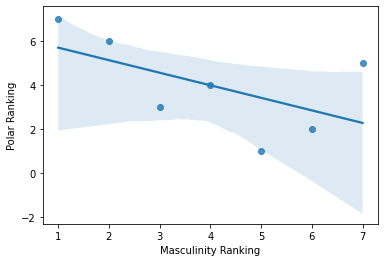

time: 272 ms (started: 2022-05-17 02:59:56 +00:00)


In [204]:
import seaborn as sns

sns.regplot(x=merged_df["Masculinity Ranking"], y=merged_df["Polar Ranking"])